# Create Fair Bingo Cards from Segmentation Stats

This notebook implements a statistical approach to generating "fair" Bingo cards based on satellite image segmentation results.

**The Goal:**
Generate $N$ Bingo cards, each with 10 squares (conditions like "Has a Pool", "More than 2 Cars").
The game is played by showing images in a random order.
"Fairness" means every card should have approximately the same **Expected Time to Win** (number of images revealed until the card is full).

**The Method:**
1. **Load Stats**: Read `segmentation_stats.csv`.
2. **Define Events**: Generate a universe of possible squares (Existence, >N, ==N).
3. **Truth Matrix**: Pre-calculate which images satisfy which events.
4. **Monte Carlo Simulation**: To measure the difficulty of a card, we simulate thousands of games (shuffling images) and calculate the average number of draws needed to complete the card.
5. **Balancing**: We generate random cards and filter/reject those that are too easy or too hard, ensuring a tight distribution of difficulty.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

# 1. Load Data
# Resolve path relative to this notebook
PROJECT_ROOT = Path.cwd().parent
CSV_PATH = PROJECT_ROOT / "mask" / "segmentation_stats.csv"

if not CSV_PATH.exists():
    raise FileNotFoundError(f"Stats file not found: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# Fill NaNs in n_objects with 0 (missing feature = 0 count)
df["n_objects"] = df["n_objects"].fillna(0).astype(int)

print(f"Loaded {len(df)} rows from {CSV_PATH}")
display(df.head())

Loaded 71 rows from /Users/dangod/Documents/GitHub/satellite-bingo/mask/segmentation_stats.csv


,image,feature,mask_file,scores_file,overlay_file,n_objects,mask_pixels,coverage_pct,coverage_area_m2,mean_score
0,/Users/dangod/Documents/GitHub/satellite-bingo...,Red car,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,1,2440,0.014064,2440.0,0.644436
1,/Users/dangod/Documents/GitHub/satellite-bingo...,Yellow car,NaN,NaN,NaN,0,0,0.000000,NaN,NaN
2,/Users/dangod/Documents/GitHub/satellite-bingo...,Red car,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,2,7818,0.048575,7818.0,0.865592
3,/Users/dangod/Documents/GitHub/satellite-bingo...,Pool,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,2,31479,0.195586,31479.0,0.898021
4,/Users/dangod/Documents/GitHub/satellite-bingo...,Wave,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,/Users/dangod/Documents/GitHub/satellite-bingo...,1,175841,1.092538,175841.0,0.581729


In [2]:
# 2. Preprocess: Create Image-Feature Count Matrix
# We want a matrix where index=Image, columns=Features, values=Count
# This makes it easy to check conditions across all images at once.

# Pivot the table
counts_matrix = df.pivot_table(index="image", columns="feature", values="n_objects", fill_value=0)

# Ensure we have all images (some might have no features and be missing if not handled carefully, 
# but here the CSV comes from a process that lists features found. 
# If an image has NO features found, it might be missing from the CSV unless the script outputted 0-count rows.
# Let's assume the CSV covers the relevant images.)

print(f"Matrix shape: {counts_matrix.shape} (Images x Features)")
display(counts_matrix.head())

Matrix shape: (28, 21) (Images x Features)


feature,Batman logo,Blue plane,Coca Cola logo,Ferry,Golf sand bunker,Island,Pool,Red car,Small boats,Wave,...,baseball court,container ship,empty parking lot,football,football field,green car,plane,solar panels,space shuttle,tennis court
image,,,,,,,,,,,,,,,,,,,,,
/Users/dangod/Documents/GitHub/satellite-bingo/converted_sat_images/image_1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/Users/dangod/Documents/GitHub/satellite-bingo/converted_sat_images/image_10.jpg,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/Users/dangod/Documents/GitHub/satellite-bingo/converted_sat_images/image_12.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
/Users/dangod/Documents/GitHub/satellite-bingo/converted_sat_images/image_13.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
/Users/dangod/Documents/GitHub/satellite-bingo/converted_sat_images/image_14.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 3. Generate Candidate Bingo Squares (Events)

def generate_events(matrix):
    events = []
    
    features = matrix.columns
    n_images = len(matrix)
    
    for feat in features:
        col = matrix[feat]
        
        # 1. Existence: "Contains a [Feature]"
        # Condition: count > 0
        mask = col > 0
        prob = mask.mean()
        if 0.001 <= prob <= 0.95: # Filter trivial or impossible events
            events.append({
                "description": f"Contains {feat}",
                "type": "exists",
                "feature": feat,
                "condition": lambda c: c > 0,
                "mask": mask.values,
                "probability": prob
            })
            
        # 2. Thresholds: "More than N [Feature]s"
        # Check reasonable thresholds based on data
        max_val = col.max()
        if max_val > 1:
            for n in range(1, min(int(max_val), 6)): # Check 1..5
                mask = col > n
                prob = mask.mean()
                if 0.05 <= prob <= 0.95:
                    events.append({
                        "description": f"More than {n} {feat}s",
                        "type": "threshold",
                        "feature": feat,
                        "condition": lambda c, n=n: c > n, # capture n
                        "mask": mask.values,
                        "probability": prob
                    })

        # 3. Exact Counts: "Exactly N [Feature]s"
        # Useful for small numbers
        if max_val >= 1:
            for n in range(1, min(int(max_val) + 1, 6)):
                mask = col == n
                prob = mask.mean()
                if 0.05 <= prob <= 0.95:
                    events.append({
                        "description": f"Exactly {n} {feat}{'s' if n>1 else ''}",
                        "type": "exact",
                        "feature": feat,
                        "condition": lambda c, n=n: c == n,
                        "mask": mask.values,
                        "probability": prob
                    })
                    
    return pd.DataFrame(events)

events_df = generate_events(counts_matrix)
print(f"Generated {len(events_df)} candidate events.")
display(events_df[["description", "probability"]].sort_values("probability").head(10))
display(events_df[["description", "probability"]].sort_values("probability", ascending=False).head(10))

Generated 62 candidate events.


,description,probability
0,Contains Batman logo,0.035714
1,Contains Blue plane,0.035714
2,Contains Coca Cola logo,0.035714
3,Contains Ferry,0.035714
32,Contains Wave,0.035714
10,Contains Island,0.035714
37,Contains baseball court,0.035714
29,More than 3 Small boatss,0.071429
60,More than 5 tennis courts,0.071429
31,More than 5 Small boatss,0.071429


,description,probability
18,Contains Red car,0.500000
19,More than 1 Red cars,0.357143
11,Contains Pool,0.357143
23,More than 5 Red cars,0.250000
22,More than 4 Red cars,0.250000
21,More than 3 Red cars,0.250000
20,More than 2 Red cars,0.250000
55,Contains tennis court,0.214286
40,Contains football field,0.214286
46,More than 1 planes,0.178571


In [4]:
# 4. Compute Truth Matrix
# Rows = Images, Cols = Events
# Value = True if Image satisfies Event
# We already stored the masks in the events_df, let's stack them.

truth_matrix = np.stack(events_df["mask"].values).T # Shape: (n_images, n_events)
print(f"Truth Matrix Shape: {truth_matrix.shape}")

# Verify
# truth_matrix[i, j] is True if Image i satisfies Event j

print(truth_matrix[1])

Truth Matrix Shape: (28, 62)
[False False False False False False False False False False False  True
  True False False False False  True  True  True False False False False
 False  True False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


In [7]:
# 5. Define Monte Carlo Simulation for Card Difficulty

def calculate_turns_to_win(card_indices, truth_matrix, n_simulations=1000000):
    """
    Simulates the game n_simulations times for a given card.
    Returns the average number of turns (images drawn) to complete the card.
    """
    n_images, n_events = truth_matrix.shape
    card_mask = truth_matrix[:, card_indices] # Shape: (n_images, 10)
    
    # If a card has an event that is NEVER satisfied by any image, it's impossible.
    # Check if any column in card_mask is all False
    if np.any(card_mask.sum(axis=0) == 0):
        return float('inf') # Impossible card
    
    turns_needed = []
    
    # Create an array of image indices [0, 1, ... N-1]
    deck = np.arange(n_images)
    
    for _ in range(n_simulations):
        np.random.shuffle(deck)
        
        # We want to find the first index k such that the union of images deck[0]...deck[k]
        # covers all requirements.
        
        # Reorder the card_mask according to the shuffled deck
        shuffled_mask = card_mask[deck] # Shape: (n_images, 10)
        
        # Cumulative sum (or rather, cumulative OR)
        # We want to know when we have seen a True for every column.
        # np.maximum.accumulate works like cumulative OR for booleans (0/1)
        covered_cum = np.maximum.accumulate(shuffled_mask, axis=0) # Shape: (n_images, 10)
        
        # Check if all 10 are covered at each step
        all_covered = covered_cum.all(axis=1) # Shape: (n_images,)
        
        # Find the first index where all_covered is True
        # argmax returns the first True index. If none are True, it returns 0 (but we checked impossibility)
        # We add 1 because turns are 1-based (1st image is index 0)
        if not all_covered.any():
             # Should not happen if we checked impossibility, unless n_images < needed?
             # But we assume infinite deck or deck=all images. 
             # If deck=all images and it's possible, it will happen.
             turns = n_images 
        else:
            turns = np.argmax(all_covered) + 1
            
        turns_needed.append(turns)
        
    return np.mean(turns_needed)

# Test with a random card
random_card_indices = random.sample(range(len(events_df)), 10)
avg_turns = calculate_turns_to_win(random_card_indices, truth_matrix)
print(f"Random Card Average Turns to Win: {avg_turns:.2f} (out of {len(counts_matrix)} images)")
print("Card Events:")
print(events_df.iloc[random_card_indices]["description"].tolist())

Random Card Average Turns to Win: 18.62 (out of 28 images)
Card Events:
['Contains Pool', 'More than 3 Golf sand bunkers', 'More than 4 Golf sand bunkers', 'More than 2 planes', 'More than 2 Pools', 'Contains Batman logo', 'Exactly 1 football field', 'Contains empty parking lot', 'More than 1 Pools', 'More than 3 planes']


In [12]:
# 6. Generate and Filter Fair Bingo Cards

NUM_CARDS = 50
CARD_SIZE = 10
TOLERANCE = 1 # Allowable deviation from target turns
MANUAL_TARGET = None # Set to a number (e.g. 45) to force a specific difficulty, or None to auto-calculate

# Pre-calculate feature groups for constrained sampling
# We want exactly one event per feature to avoid "Contains Pool" AND "More than 2 Pools" on same card
feature_groups = events_df.groupby("feature").indices # dict: feature -> array of positional indices
unique_features = list(feature_groups.keys())

if len(unique_features) < CARD_SIZE:
    raise ValueError(f"Cannot create cards of size {CARD_SIZE}: Only {len(unique_features)} unique features available.")

# First, estimate a "Target Difficulty" by sampling random cards
print("Estimating baseline difficulty...")
sample_difficulties = []
for _ in range(50):
    # Generate a random constrained card for baseline
    feats = random.sample(unique_features, CARD_SIZE)
    idxs = [random.choice(feature_groups[f]) for f in feats]
    d = calculate_turns_to_win(idxs, truth_matrix, n_simulations=100)
    if d != float('inf'):
        sample_difficulties.append(d)

if MANUAL_TARGET is not None:
    target_difficulty = MANUAL_TARGET
    print(f"Using Manual Target Average Turns to Win: {target_difficulty:.2f}")
else:
    target_difficulty = np.median(sample_difficulties)
    print(f"Calculated Target Average Turns to Win (Median): {target_difficulty:.2f}")

final_cards = []
final_stats = []

print(f"Generating {NUM_CARDS} fair cards...")
pbar = tqdm(total=NUM_CARDS)

attempts = 0
MAX_ATTEMPTS = NUM_CARDS * 5000 # Safety break

while len(final_cards) < NUM_CARDS:
    attempts += 1
    
    # 1. Pick N unique features (The "Combination")
    # We stick with this set of features and try to find a working configuration of events
    selected_features = random.sample(unique_features, CARD_SIZE)
    
    # 2. Try to find a valid configuration for these features
    # We'll try multiple times to find a valid set of conditions (events) for these specific features
    # before giving up and picking a new set of features.
    # This helps if a feature set is "good" but we just picked the wrong difficulty options (e.g. >5 instead of >1)
    
    found_config = False
    for _ in range(100): # Try 1000 variations for this feature set
        card_idxs = []
        for feat in selected_features:
            possible_idxs = feature_groups[feat]
            card_idxs.append(random.choice(possible_idxs))
            
        # Check Difficulty
        # Fast check first
        est_diff = calculate_turns_to_win(card_idxs, truth_matrix, n_simulations=50)
        
        if abs(est_diff - target_difficulty) < TOLERANCE * 2:
            # If promising, run precise check
            precise_diff = calculate_turns_to_win(card_idxs, truth_matrix, n_simulations=50000)
            
            if abs(precise_diff - target_difficulty) < TOLERANCE:
                # Accepted!
                final_cards.append(card_idxs)
                final_stats.append(precise_diff)
                pbar.update(1)
                found_config = True
                break # Break inner loop, move to next card
    
    if attempts > MAX_ATTEMPTS:
        print("Warning: Difficulty finding cards. Try widening tolerance or changing target.")
        break
        
pbar.close()
print(f"Generated {len(final_cards)} cards.")

Estimating baseline difficulty...
Calculated Target Average Turns to Win (Median): 23.34
Generating 50 fair cards...


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 50 cards.


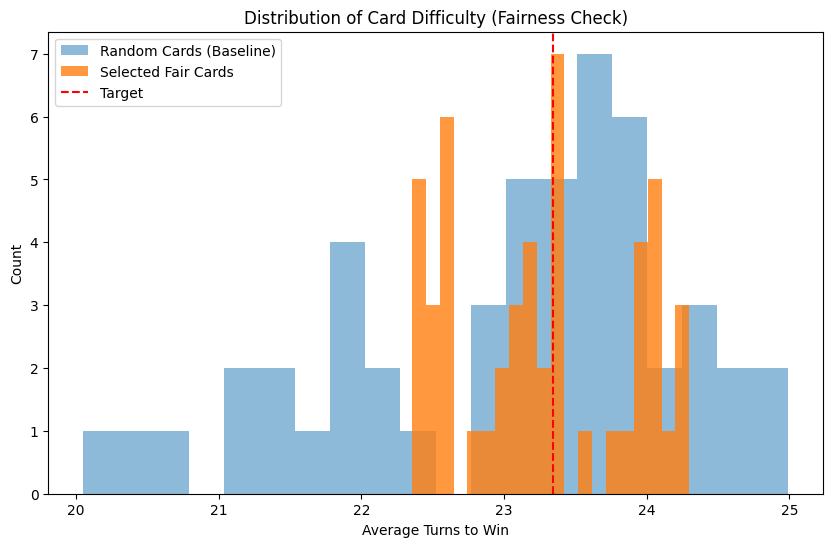

Baseline Std Dev: 1.18
Selected Std Dev: 0.61


In [13]:
# 7. Validate Fairness Distribution

plt.figure(figsize=(10, 6))
plt.hist(sample_difficulties, bins=20, alpha=0.5, label='Random Cards (Baseline)')
plt.hist(final_stats, bins=20, alpha=0.8, label='Selected Fair Cards')
plt.axvline(target_difficulty, color='r', linestyle='--', label='Target')
plt.xlabel('Average Turns to Win')
plt.ylabel('Count')
plt.title('Distribution of Card Difficulty (Fairness Check)')
plt.legend()
plt.show()

print(f"Baseline Std Dev: {np.std(sample_difficulties):.2f}")
print(f"Selected Std Dev: {np.std(final_stats):.2f}")

In [15]:
# 8. Export Final Bingo Cards

cards_data = []
for i, idxs in enumerate(final_cards):
    card_events = events_df.iloc[idxs]["description"].tolist()
    cards_data.append({
        "card_id": i + 1,
        "events": card_events,
        "avg_turns_to_win": final_stats[i]
    })
    
# Display first card as example
print("Example Card 1:")
for e in cards_data[0]["events"]:
    print(f"- {e}")
    
# Save to JSON
import json
out_file = PROJECT_ROOT / "bingo_cards.json"
with open(out_file, "w") as f:
    json.dump(cards_data, f, indent=2)
    
print(f"Saved {len(cards_data)} cards to {out_file}")

Example Card 1:
- More than 2 Golf sand bunkers
- Contains Coca Cola logo
- Contains baseball court
- Contains plane
- Contains space shuttle
- Contains Ferry
- Contains empty parking lot
- Contains Batman logo
- More than 5 tennis courts
- More than 3 Yellow cars
Saved 50 cards to /Users/dangod/Documents/GitHub/satellite-bingo/bingo_cards.json
